# hyperparameter tuning for `XGBClassifier`


In [4]:
import optuna

In [144]:
from xgboost import XGBClassifier

import utils
import pandas as pd
from sklearn.metrics import roc_auc_score,f1_score,roc_curve,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
df = pd.read_csv('cleaned_data.csv')
(Xtrain,ytrain),(Xtest,ytest)=utils.get_train_test(df,'target',scale='standard')

In [154]:
def objective (trail):
    params={
      'learning_rate':trail.suggest_float('learning_rate',1e-3,1e-1,log=True),
      'max_depth':trail.suggest_int('max_depth',1,10),
      'min_child_weight':trail.suggest_int('min_child_weight',1,10),
      'subsample':trail.suggest_float('subsample',0.5,1),
      'colsample_bytree':trail.suggest_float('colsample_bytree',0.5,1),
      'reg_alpha':trail.suggest_float('reg_alpha',0,1),
      'reg_lambda':trail.suggest_float('reg_lambda',0,1),
 }
    model=  XGBClassifier(**params ,random_state=42)
    model.fit(Xtrain,ytrain)
    proba=model.predict_proba(Xtest)[:,1]
    return roc_auc_score(ytest,proba)

In [155]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2025-11-02 21:40:02,787] A new study created in memory with name: no-name-7f11db16-12d3-4976-940f-79fad75cec98
[I 2025-11-02 21:40:02,869] Trial 0 finished with value: 0.9268115062507586 and parameters: {'learning_rate': 0.009281334328549683, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.6134993744970825, 'colsample_bytree': 0.8593890734381837, 'reg_alpha': 0.3887339344909363, 'reg_lambda': 0.4948151656512818}. Best is trial 0 with value: 0.9268115062507586.
[I 2025-11-02 21:40:02,929] Trial 1 finished with value: 0.8819031435853865 and parameters: {'learning_rate': 0.0018026304233459307, 'max_depth': 1, 'min_child_weight': 2, 'subsample': 0.9036567451897966, 'colsample_bytree': 0.923921340172154, 'reg_alpha': 0.36619707508210375, 'reg_lambda': 0.9527642805665484}. Best is trial 0 with value: 0.9268115062507586.
[I 2025-11-02 21:40:03,107] Trial 2 finished with value: 0.9033863332928754 and parameters: {'learning_rate': 0.001083267355148478, 'max_depth': 5, 'min_child_weight

In [156]:
study.best_value

0.9516931666464377

In [157]:
result = study.trials_dataframe().drop(columns=['number','datetime_start', 'datetime_complete', 'duration','state'])

In [158]:
result.columns

Index(['value', 'params_colsample_bytree', 'params_learning_rate',
       'params_max_depth', 'params_min_child_weight', 'params_reg_alpha',
       'params_reg_lambda', 'params_subsample'],
      dtype='object')

In [159]:
study.best_params

{'learning_rate': 0.07758517883053227,
 'max_depth': 4,
 'min_child_weight': 4,
 'subsample': 0.8961055130263316,
 'colsample_bytree': 0.9674798316242659,
 'reg_alpha': 0.7118086835901646,
 'reg_lambda': 0.4529120328263342}

In [160]:
import altair as alt
alt.Chart(result).mark_point().encode(
    x=alt.X('params_learning_rate',scale=alt.Scale(type='log'))
    ,y='value'
)

alt.Chart(...)

for `learning_rate` >0.05 the model perform well


In [161]:
alt.Chart(result).mark_point().encode(
    x=alt.X('params_reg_alpha')
    ,y='value'
)

alt.Chart(...)

for params_l2_regularization > 0.5 the model perform well


In [162]:
alt.Chart(result).mark_point().encode(
    x=alt.X('params_reg_lambda')
    ,y='value'
)

alt.Chart(...)

In [163]:
alt.Chart(result).mark_point().encode(
    x='params_max_depth'
    ,y='value'
)

alt.Chart(...)

kernel rbf is the best for the model


In [164]:
import json
with open('best_params_xgb.json','w') as f:
    json.dump(study.best_params,f)

In [165]:
model=  XGBClassifier(random_state=42)
best=  XGBClassifier(**study.best_params ,random_state=42)


In [166]:
model.fit(Xtrain,ytrain)
best.fit(Xtrain,ytrain)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9674798316242659, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07758517883053227,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [167]:
proba_base = model.predict_proba(Xtest)[:,1]
proba_best = best.predict_proba(Xtest)[:,1]
fp_base,tp_base,_ =roc_curve(ytest,proba_base)
fp_best,tp_best,_ =roc_curve(ytest,proba_best)



In [168]:
s=alt.Chart(pd.DataFrame({'0':[0,1],'1':[0,1]})).mark_line(
    color='red',
   strokeDash=[5,5]
).encode(
    x='0',
    y='1'
)
roc_base=alt.Chart(pd.DataFrame({'fp':fp_base,'tp':tp_base})).mark_line().encode(
    x='fp',
    y='tp'
)+s
roc_best=alt.Chart(pd.DataFrame({'fp':fp_best,'tp':tp_best})).mark_line().encode(
    x='fp',
    y='tp'
)+s



In [169]:
roc_base.properties(title='base model')|roc_best.properties(title='best model')

alt.HConcatChart(...)

Threshold tuning


In [131]:
import numpy as np

In [170]:
thresholds=np.arange(0,1,0.001)
f1_base=[]
f1_best=[]
for threshold in thresholds:
    pred_base=(proba_base>threshold).astype(int)
    pred_best=(proba_best>threshold).astype(int)
    f1_base.append(f1_score(ytest,pred_base))
    f1_best.append(f1_score(ytest,pred_best))

In [171]:
np.max(f1_base),np.max(f1_best)

(np.float64(0.9134615384615384), np.float64(0.9140271493212669))

In [172]:
threshold_base=thresholds[np.argmax(f1_base)]
threshold_best=thresholds[np.argmax(f1_best)]
threshold_base,threshold_best

(np.float64(0.367), np.float64(0.241))

In [173]:
pred_base=(proba_base>threshold_base).astype(int)
pred_best=(proba_best>threshold_best).astype(int)
cm_base=pd.DataFrame(confusion_matrix(ytest,pred_base),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])
cm_best=pd.DataFrame(confusion_matrix(ytest,pred_best),columns=['Pred 0','Pred 1'],index=['Actual 0','Actual 1'])


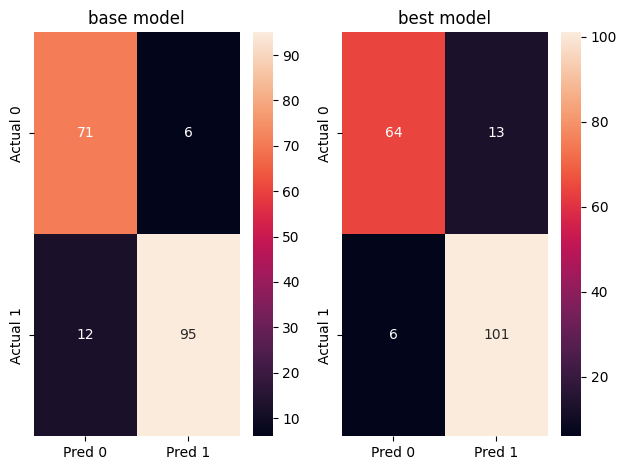

In [174]:
plt.subplot(1,2,1)
sns.heatmap(cm_base,annot=True,fmt='d')
plt.title('base model')
plt.subplot(1,2,2)
sns.heatmap(cm_best,annot=True,fmt='d')
plt.title('best model')
plt.tight_layout()